In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.pyplot
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
## Load images of vehicle and non-vehicle images

cars = glob.glob('./vehicles/**/*.png')
notcars = glob.glob('./non-vehicles/**/*.png')

print ('Number of vehicle images found : ', len(cars))
print ('Number of vehicle images found : ', len(notcars))


Number of vehicle images found :  8792
Number of vehicle images found :  8968


In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs (features and visulization) if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise get features only
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features



In [5]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features   

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True,
                     viz=False, viz_only=False, hog_viz_name="", viz_title="HOG Viz"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        # Adding features in order (spatial_feat, hist_feat, hog_feat) to file_features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if viz == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature, hog_image = get_hog_features(feature_image[:, :, channel],
                                                                  orient, pix_per_cell, cell_per_block,
                                                                  vis=True, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                               pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                # Plot HOG visualisation

                if viz_only == True:
                    fig = plt.figure()
                    plt.imshow(hog_image)
                    plt.title(viz_title)
                    plt.savefig(hog_viz_name, bbox_inches='tight')

                else:
                    fig = plt.figure()
                    plt.subplot(121)
                    plt.imshow(image)
                    plt.title('Example Image')
                    plt.subplot(122)
                    plt.imshow(hog_image)
                    plt.title('Example HOG viz')
                    plt.savefig(hog_viz_name + "_double", bbox_inches='tight')

            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature = get_hog_features(feature_image[:, :, channel],
                                                       orient, pix_per_cell, cell_per_block,
                                                       vis=False, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



In [7]:

# window size (x and y are dimension)
# and overlap fraction (for both x and y)

def slide_window(img,x_start_stop=[None,None],y_start_stop=[None,None], 
                 xy_window=(64,64), xy_overlap=(0.5,0.5)):
    # If x and/or y start/stop positions not defined, set to image size 
    if(x_start_stop[0] == None):
        x_start_stop[0] = 0 
    if(x_start_stop[1] == None):
        x_start_stop[1] = img.shape[1]
    if(y_start_stop[0] == None):
        y_start_stop[0] = 0 
    if(y_start_stop[1] == None):
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window position to 
    
    window_list = [] 
    # Loop through finding x and y window positions 
    # Note: you could vectorize this step, but in practice 
    # you will be considering windows one by one with your classifier , so looping makes sense 
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
        
        # Append window position to list 
        window_list.append(((startx,starty),(endx,endy)))
        
    # Return the list of windows     
    return window_list


In [8]:

# Define a function to draw bounding boxes

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=5):
    # Make a copy of the images
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with the boxes drawn
    return imcopy

   

In [9]:
# This function is very similar to extract_features()
# Just for a single image rather than the list of images.

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):


    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than RGB
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)

    if (spatial_feat == True):
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if (hist_feat == True):
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if (hog_channel == 'ALL'):
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                     orient, pix_per_cell, cell_per_block,
                                     vis=False,feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:            
            if (vis == True):
                hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                       pix_per_cell, cell_per_block, vis=True, feature_vec=True)            
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list 
        img_features.append(hog_features)            

    if vis == True:
        return np.concatenate(img_features), hog_image
    else : 
        return np.concatenate(img_features)

        


In [10]:
  #   Define a function you will pass an image
  #   and the list of windows to be searched (output of slide_windows())

def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32,32), hist_bins=32,
                   hist_range=(0,256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, 
                   hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image and resize to (64,64)        
        test_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]],(64,64))
        #test_img = img
            
        #4) Extract features for that window using single img_feature()
        features = single_img_features(test_img,color_space=color_space,
                                       spatial_size=spatial_size,hist_bins=hist_bins,
                                       orient=orient,pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel,spatial_feat=spatial_feat,
                                       hist_feat=hist_feat,hog_feat=hog_feat)

        #5) Scale extracted to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1,-1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) if positive (prediction == 1) then save the window
        if(prediction ==1 ):
            on_windows.append(window)

    return on_windows


    

In [11]:
# Define a function for plotting multiple images
def visualize(fig,rows,cols,imgs,titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape) 
        if img_dims < 3:            
            plt.imshow(img, cmap='hot')                
            plt.title(titles[i])
        else:
            plt.imshow(img)                
            plt.title(titles[i])

/Users/SB/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


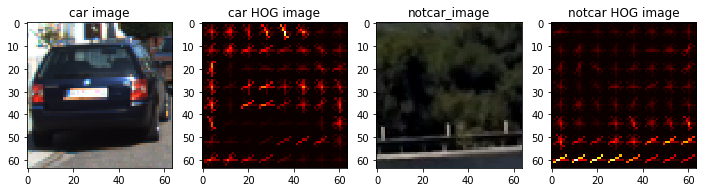

In [12]:
%matplotlib inline

#Choose random car / not-car indices 
car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Define feature parametes 
color_space = 'RGB'# can be RGB, HSV, LUV, HLS, YUV , YCr
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16
hist_range= (0,256)
spatial_feat = True
hist_feat = True
hog_feat = True 
vis = True


car_features, car_hog_image = single_img_features(car_image, color_space, spatial_size,
                            hist_bins, orient,pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, 
                            hist_feat, 
                            hog_feat, 
                            vis)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space, spatial_size,
                            hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat, vis)

images = [car_image,car_hog_image,notcar_image,notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar_image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [13]:
#TODO 22:34 - Above is for HOG feature, do it for histogram binning and spatial binning and 

In [14]:
#Define feature parameters

color_space = 'YCrCb'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)  # Spatial binning dimensions 
hist_bins = 32          # Number of histogram bins 
spatial_feat = True     # Spatial feature is on or off 
hist_feat = True        # Histogram features is on or off 
hog_feat = True         # HOG features is on or off 

t = time.time()

n_samples = 1000

random_idxs = np.random.randint(0,len(cars),n_samples)

test_cars = cars #np.array(cars)[random_idxs]

test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient,pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,spatial_feat=spatial_feat,
                                hist_feat=hist_feat,hog_feat=hog_feat)

notcar_features = extract_features(test_notcars,color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient,pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel,spatial_feat=spatial_feat,
                                    hist_feat=hist_feat,hog_feat=hog_feat)

print (time.time()-t, 'Seconds to compare features...')

X = np.vstack((car_features,notcar_features)).astype(np.float64)

#Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
                                
# Apply the scaler to X 
scaled_X = X_scaler.transform(X)
                                
# Define the labels vector 
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features)))) 
                                
# Splot up data into randomized training and test sets
rand_state = np.random.randint(0,100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)
                                
print('Using:', orient, 'orientations,', pix_per_cell,
      'pixel per cell',cell_per_block,'cells per block,', 
      hist_bins,'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t,2),'Seconds to train SVC...')
#Check the score of the SVC 
print('Test Accuracy of SVC = ', round (svc.score(X_test, y_test),4))


/Users/SB/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


189.28491806983948 Seconds to compare features...
Using: 9 orientations, 8 pixel per cell 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
43.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


In [15]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [None, None] # Min and max in y to search in slide_window()

overlap = 0.5

for img_src in example_images: 
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #print(np.min(img), np.max(img))

    #windows 
    windows = slide_window(img,x_start_stop=[None, None],y_start_stop=y_start_stop,
                          xy_window=(64,64),xy_overlap=(overlap,overlap))
    
    windows = slide_window(img,x_start_stop=[None, None],y_start_stop=y_start_stop,
                          xy_window=(96,96),xy_overlap=(overlap,overlap))
    
    #print(windows)
    #windows = window1 + window2 
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space = color_space,
                                 spatial_size = spatial_size, hist_bins=hist_bins, 
                                 hist_range=hist_range,orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                 hog_channel = hog_channel, 
                                 spatial_feat=spatial_feat,
                                 hist_feat=hist_feat,
                                 hog_feat=hog_feat)
  
    window_img = draw_boxes(draw_img, hot_windows, color= (0,0,255),thick = 6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows),'windows')

fig = plt.figure(figsize=(12,18),dpi=300)
visualize(fig,5,2,images,titles)

/Users/SB/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.427807092666626 seconds to process one image searching 14 windows
0.21463513374328613 seconds to process one image searching 14 windows
0.19854998588562012 seconds to process one image searching 14 windows
0.20535683631896973 seconds to process one image searching 14 windows
0.21339917182922363 seconds to process one image searching 14 windows
0.20762896537780762 seconds to process one image searching 14 windows


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [16]:
def convert_color(img,conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2LUV)

In [ ]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
# Consider a narrower swatch in y
ystart = 400
ystop = 656
scale = 1.5 

#Iterate over the test images 

for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img  = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale),
                                                      np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block **2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image 
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this Patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features= np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell 
            
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window],(64,64))
            
            # Get color features 
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,hog_features)).reshape(1,-1))
            #test_features = X_scaler.trasnform(np.hstack((shape_fit,hist_feat)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left,ytop_draw + ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw + ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
            
        print(time.time()-t, 'seconds to run, total_windows =', count)
        
        out_images.append(draw_img)
        
        out_titles.append(img_src[-12:])
        
        #heatmap = 255*heatmap/np.max(heatmap)
        out_images.append(heatmap)
        out_maps.append(heatmap)
        out_boxes.append(img_boxes)

    fig = plt.figure(figsize=(12,24))   
    visualize(fig,8,2,out_images,out_titles)

In [21]:
def find_cars(img, scale) : 
    
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img  = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale),
                                                      np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block **2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image 
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this Patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features= np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell 
            
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window],(64,64))
            
            # Get color features 
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,hog_features)).reshape(1,-1))
            #test_features = X_scaler.trasnform(np.hstack((shape_fit,hist_feat)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left,ytop_draw + ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw + ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
            
    return draw_img,heatmap
    
    

In [22]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heamap[heatmap <= threshold] = 0
    # Return threshold map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1,labels[1]+1):
        # Find pixels with each car number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels 
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y 
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image 
        cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)        
    return img



/Users/SB/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


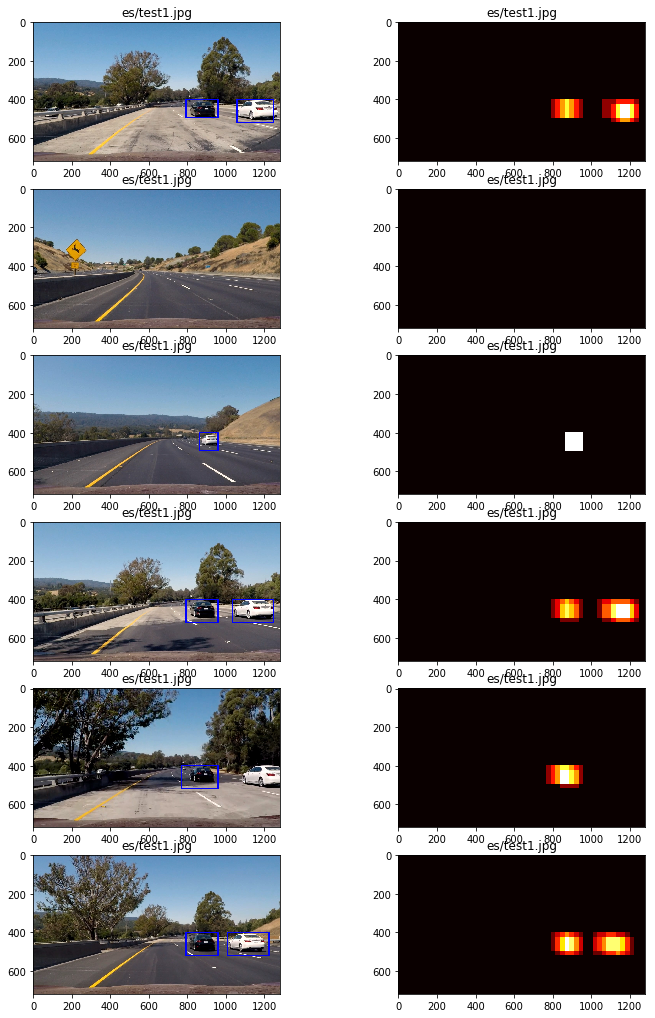

In [23]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5

# Iterate over the test images 
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img,scale)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the images 
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualize(fig,8,2,out_images,out_titles)


In [24]:
def process_image(img):
    
    out_img, heat_map = find_cars(img,scale)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img),labels)
    return draw_img


In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML 

test_output = 'project_video_out.mp4'
#clip = VideoFileClip('test_video.mp4')
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
#%time
print(test_output)
test_clip.write_videofile(test_output,audio=False)


project_video_out.mp4
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [15:22<00:00,  1.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [26]:
HTML("""
<video width="960" height="540"controls>
    <source src="{0}">
</video>
""".format(test_output))